In [220]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_absolute_error, mean_squared_error
from xgboost import XGBClassifier, XGBRegressor
import warnings
import chess.engine
import chess.svg
from IPython.display import display, SVG, clear_output
import time
from tqdm import tqdm
from stockfish import Stockfish
import chess.pgn
import chess
import mmh3
import random

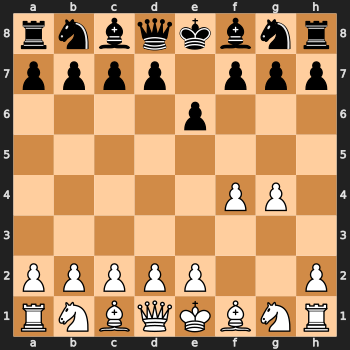

material imbalance -1.0
encoded board [4, 2, 3, 5, 6, 3, 2, 4, 1, 1, 1, 1, 1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -4, -2, -3, -5, -6, -3, -2, -4]
count pieces (16, 16)
count pieces by type (8, 1, 2, 2, 2, 8, 1, 2, 2, 2)
number of open files 0
king safety (0.5, 3.5, 2)
number of semi open files (0, 0)
count controlled squares (26, 29)
count minor pieces on back rank (4, 4)
count pieces under attack (0, 0)
None
False False
[{'Move': 'd8h4', 'Centipawn': None, 'Mate': -1}, {'Move': 'a7a5', 'Centipawn': -115, 'Mate': None}, {'Move': 'b8c6', 'Centipawn': -71, 'Mate': None}, {'Move': 'h7h5', 'Centipawn': -70, 'Mate': None}, {'Move': 'd7d5', 'Centipawn': -65, 'Mate': None}]
None


In [314]:
# Utility functions
stockfish = Stockfish(path="datasets/chess/stockfish", depth=2)


def compute_material_imbalance(board):
    piece_values = {'p': -1, 'P': 1, 'n': -3, 'N': 3, 'b': -3, 'B': 3, 'r': -5, 'R': 4.5, 'q': -9, 'Q': 9}
    fen = board.fen().split(' ')[0]  # Get only the piece placement data from the FEN string

    # Initialize variable to keep track of material imbalance
    material_imbalance = 0

    # Iterate through the FEN string and calculate material values
    for char in fen:
        material_imbalance += piece_values.get(char, 0)  # Default to 0 if the character does not represent a piece

    return material_imbalance

def encoded_board(board):
    # Initialize a 64x64 vector with -1 for empty squares
    board_vector = [-1] * 64

    # Iterate through the board and populate the vector with piece encodings
    for square in chess.SQUARES:
        piece = board.piece_at(square)
        if piece is not None:
            # Encode the piece based on its type
            if piece.color == chess.WHITE:
                board_vector[square] = piece.piece_type
            else:
                # For black pieces, encode as negative values
                board_vector[square] = -piece.piece_type
    return board_vector

def count_pieces(board):
    fen = board.fen().split(' ')[0]  # Get only the piece placement part of the FEN string
    
    white_piece_count = 0
    black_piece_count = 0
    
    for char in fen:
        if char.isalpha():
            if char.isupper():  # White pieces are represented by uppercase letters
                white_piece_count += 1
            else:  # Black pieces are represented by lowercase letters
                black_piece_count += 1
                
    return white_piece_count, black_piece_count

def count_value_of_pieces_under_attack(board):
    piece_values = {chess.PAWN: 1, chess.KNIGHT: 3, chess.BISHOP: 3, chess.ROOK: 4.5, chess.QUEEN: 9}
    
    white_value_under_attack = 0
    black_value_under_attack = 0

    for square in chess.SQUARES:
        piece = board.piece_at(square)

        if piece is None:
            continue

        attackers = board.attackers(not piece.color, square)  # Get the squares of all attacking pieces

        if attackers:  # Check if there are any attackers
            piece_value = piece_values.get(piece.piece_type, 0)
            if piece.color == chess.WHITE:
                white_value_under_attack += piece_value
            else:
                black_value_under_attack += piece_value

    return white_value_under_attack, black_value_under_attack

def number_of_semi_open_files(board):
    white_semi_open_files = 0
    black_semi_open_files = 0
    
    # Loop through each file (from 'a' to 'h')
    for file in range(8):
        white_pawns = 0
        black_pawns = 0
        
        # Loop through each rank (from 1 to 8)
        for rank in range(8):
            square = chess.square(file, rank)
            piece = board.piece_at(square)
            
            if piece is not None and piece.piece_type == chess.PAWN:
                if piece.color == chess.WHITE:
                    white_pawns += 1
                else:
                    black_pawns += 1
        
        # Check for semi-open files
        if white_pawns == 0 and black_pawns > 0:
            white_semi_open_files += 1
        if black_pawns == 0 and white_pawns > 0:
            black_semi_open_files += 1
            
    return white_semi_open_files, black_semi_open_files

def king_safety(board, color):
    safety_score = [0, 0, 0]
    
    # Find the king's square
    king_square = board.king(color)
    if king_square is None:
        return -1000  # King is captured, so safety is extremely low
    
    king_file = chess.square_file(king_square)
    king_rank = chess.square_rank(king_square)
    
    # Penalize king's proximity to the board center
    safety_score[0] = (abs(3.5 - king_file))
    safety_score[1] = (abs(3.5 - king_rank))

    
    # Check for pawn shields only in front of the king
    rank_direction = 1 if color == chess.WHITE else -1
    front_rank = king_rank + rank_direction  # the rank immediately in front of the king
    
    if front_rank < 0 or front_rank > 7:
        # If the front rank is out of bounds, skip this part
        return safety_score
    
    for file_offset in [-1, 0, 1]:
        file = king_file + file_offset
        if file < 0 or file > 7:
            continue
            
        square = chess.square(file, front_rank)
        piece = board.piece_at(square)
        
        if piece and piece.color == color and piece.piece_type == chess.PAWN:
            safety_score[2] += 1


    return safety_score[0], safety_score[1], safety_score[2]

def count_controlled_squares(board):
    white_control = 0
    black_control = 0
    
    for square in chess.SQUARES:
        if board.is_attacked_by(chess.WHITE, square):
            white_control += 1
        if board.is_attacked_by(chess.BLACK, square):
            black_control += 1
            
    return white_control, black_control

def count_minor_pieces_on_back_rank(board):
    white_back_rank = 0
    black_back_rank = 0
    
    # Squares for the back rank for white and black
    white_back_rank_squares = [chess.A1, chess.B1, chess.C1, chess.D1, chess.E1, chess.F1, chess.G1, chess.H1]
    black_back_rank_squares = [chess.A8, chess.B8, chess.C8, chess.D8, chess.E8, chess.F8, chess.G8, chess.H8]
    minor_pieces = [chess.KNIGHT, chess.BISHOP]
    
    for square in white_back_rank_squares:
        piece = board.piece_at(square)
        if piece is not None and piece.color == chess.WHITE and piece.piece_type in minor_pieces:
            white_back_rank += 1
            
    for square in black_back_rank_squares:
        piece = board.piece_at(square)
        if piece is not None and piece.color == chess.BLACK and piece.piece_type in minor_pieces:
            black_back_rank += 1
            
    return white_back_rank, black_back_rank



def count_pieces_by_type_from(board):
    fen = board.fen().split(' ')[0]  # Get only the piece placement data from the FEN string
    
    # Initialize counters for each type of piece for both white and black
    white_pawns = 0
    white_queens = 0
    white_rooks = 0
    white_bishops = 0
    white_knights = 0
    
    black_pawns = 0
    black_queens = 0
    black_rooks = 0
    black_bishops = 0
    black_knights = 0
    
    # Iterate through the FEN string and count the pieces
    for char in fen:
        if char == 'P':
            white_pawns += 1
        elif char == 'Q':
            white_queens += 1
        elif char == 'R':
            white_rooks += 1
        elif char == 'B':
            white_bishops += 1
        elif char == 'N':
            white_knights += 1
        elif char == 'p':
            black_pawns += 1
        elif char == 'q':
            black_queens += 1
        elif char == 'r':
            black_rooks += 1
        elif char == 'b':
            black_bishops += 1
        elif char == 'n':
            black_knights += 1

    return white_pawns, white_queens, white_rooks, white_bishops, white_knights, black_pawns, black_queens, black_rooks, black_bishops, black_knights

def generate_feature_vector(board):
    # Initialize an empty list to hold the feature vector
    feature_vector = []

    # Add whose turn it is to the feature vector
    feature_vector.append(int(board.turn))
    
    # Add the material imbalance to the feature vector
    material_imbalance = compute_material_imbalance(board)
    feature_vector.append(material_imbalance)

    # Encode the board and append it to the feature vector
    board_vector = encoded_board(board)
    feature_vector.extend(board_vector)

    # Check or Checkmate situation
    feature_vector.append(int(board.is_check()))
    feature_vector.append(int(board.is_checkmate()))

    # Castling rights
    feature_vector.append(int(board.has_kingside_castling_rights(chess.WHITE)))
    feature_vector.append(int(board.has_queenside_castling_rights(chess.WHITE)))
    feature_vector.append(int(board.has_kingside_castling_rights(chess.BLACK)))
    feature_vector.append(int(board.has_queenside_castling_rights(chess.BLACK)))

    # Add the king positions to the feature vector
    white_king_square = board.king(chess.WHITE)
    black_king_square = board.king(chess.BLACK)
    feature_vector.append(white_king_square)
    feature_vector.append(black_king_square)

    # count the number of pieces for each side
    white_pawns, white_queens, white_rooks, white_bishops, white_knights, black_pawns,\
        black_queens, black_rooks, black_bishops, black_knights = count_pieces_by_type(board)
    feature_vector.append(white_pawns)
    feature_vector.append(white_queens)
    feature_vector.append(white_rooks)
    feature_vector.append(white_bishops)
    feature_vector.append(white_knights)
    feature_vector.append(black_pawns)
    feature_vector.append(black_queens)
    feature_vector.append(black_rooks)
    feature_vector.append(black_bishops)
    feature_vector.append(black_knights)

    # Add the number of semi-open files to the feature vector
    white_semi_open_files, black_semi_open_files = number_of_semi_open_files(board)
    feature_vector.append(white_semi_open_files)
    feature_vector.append(black_semi_open_files)

    # Add the king safety to the feature vector
    white_king_safety = king_safety(board, chess.WHITE)
    black_king_safety = king_safety(board, chess.BLACK)
    feature_vector.extend(white_king_safety)
    feature_vector.extend(black_king_safety)

    # Add the number of controlled squares to the feature vector
    white_control, black_control = count_controlled_squares(board)
    feature_vector.append(white_control)
    feature_vector.append(black_control)

    # Add the number of pieces on the back rank to the feature vector
    white_back_rank, black_back_rank = count_minor_pieces_on_back_rank(board)
    feature_vector.append(white_back_rank)
    feature_vector.append(black_back_rank)

    # Add the number of pieces under attack to the feature vector
    white_under_attack, black_under_attack = count_value_of_pieces_under_attack(board)
    feature_vector.append(white_under_attack)
    feature_vector.append(black_under_attack)

    return np.array(feature_vector)

def get_stockfish_eval(fen_str):
    stockfish.set_fen_position(fen_str)
    if board.is_game_over():
        return None
    elif stockfish.get_top_moves(3)[0]['Mate'] is not None:
        return None
    else:
        return stockfish.get_top_moves(3)[0]['Centipawn']



# Test the functions

#test_fen = 'r2qkbr1/3b2p1/pP6/3p3p/3Q2P1/P3Bn2/1P2N1P1/R1K2B1R b - - 0 24'
test_fen = 'rnbqkbnr/ppppp2p/8/5pp1/8/3PP3/PPP2PPP/RNBQKBNR w KQkq - 0 3'
test_fen = 'rnbqkbnr/pppp1ppp/4p3/8/5PP1/8/PPPPP2P/RNBQKBNR b KQkq - 0 2'
board = chess.Board(test_fen)
display(SVG(chess.svg.board(board=board, size=350)))

print(f'material imbalance {compute_material_imbalance(chess.Board(test_fen))}')
print(f'encoded board {encoded_board(chess.Board(test_fen))}')
print(f'count pieces {count_pieces(chess.Board(test_fen))}')

white_pawns, white_queens, white_rooks, white_bishops, white_knights, black_pawns,\
    black_queens, black_rooks, black_bishops, black_knights = count_pieces_by_type(board)
print(f'count pieces by type {white_pawns, white_queens, white_rooks, white_bishops, white_knights, black_pawns, black_queens, black_rooks, black_bishops, black_knights}')

print(f'number of open files {number_of_open_files(chess.Board(test_fen))}')
print(f'king safety {king_safety(chess.Board(test_fen), chess.WHITE)}')
print(f'number of semi open files {number_of_semi_open_files(chess.Board(test_fen))}')

print(f'count controlled squares {count_controlled_squares(chess.Board(test_fen))}')
print(f'count minor pieces on back rank {count_minor_pieces_on_back_rank(chess.Board(test_fen))}')
print(f'count pieces under attack {count_value_of_pieces_under_attack(chess.Board(test_fen))}')

print(get_stockfish_eval(test_fen))
stockfish.set_fen_position(test_fen)
print(board.is_checkmate(), board.turn)
print(stockfish.get_top_moves())
print(get_stockfish_eval(test_fen))



In [315]:
# Create a list to store FEN strings
lst_of_feature_vectors = []
lst_of_fens = []
X = []
y = []
limit = 1500

# Open the PGN file
with open("datasets/chess/lichess_db_standard_rated_2013-02.pgn") as pgn_file:
    count = 0
    for i in tqdm(range(limit)):
        # Read a game from the PGN file
        game = chess.pgn.read_game(pgn_file)
        # Break if no more games are in the file
        if game is None:
            break

        board = game.board()
        for move in game.mainline_moves():
            board.push(move)
            feature_vector = generate_feature_vector(board)
            lst_of_feature_vectors.append(feature_vector)
            y.append(get_stockfish_eval(board.fen()))

X = np.array(lst_of_feature_vectors)
y = np.array(y)

filtered_X = [X[i] for i in range(len(y)) if y[i] is not None]
filtered_y = [val for val in y if val is not None]
X, y = np.array(filtered_X), np.array(filtered_y)


print(X.shape, y.shape)
print(min(y), max(y))
data = np.concatenate([X, y.reshape(-1, 1)], axis=1)
data = pd.DataFrame(data)
print(data.head())
print(data.shape)
data.to_csv("datasets/chess/lichess_eval.csv", index=False, header=False)


100%|██████████| 1500/1500 [05:56<00:00,  4.21it/s]


(97177, 98) (97177,)
-7583 5379
    0    1    2    3    4    5    6    7    8    9   ...   89   90   91    92  \
0  0.0 -1.0  4.0  2.0  3.0  5.0  6.0  3.0  2.0  4.0  ...  0.5  3.5  3.0  29.0   
1  1.0 -1.0  4.0  2.0  3.0  5.0  6.0  3.0  2.0  4.0  ...  0.5  3.5  2.0  29.0   
2  0.0  0.0  4.0  2.0  3.0  5.0  6.0  3.0  2.0  4.0  ...  0.5  3.5  2.0  29.0   
3  1.0  0.0  4.0  2.0  3.0  5.0  6.0  3.0  2.0  4.0  ...  0.5  3.5  1.0  29.0   
4  0.0  1.0  4.0  2.0  3.0  5.0  6.0  3.0  2.0  4.0  ...  0.5  3.5  1.0  29.0   

     93   94   95   96   97     98  
0  22.0  4.0  4.0  0.0  0.0   47.0  
1  28.0  4.0  4.0  1.0  1.0    9.0  
2  26.0  4.0  4.0  1.0  0.0   51.0  
3  29.0  4.0  4.0  1.0  1.0   78.0  
4  31.0  4.0  4.0  2.0  1.0  112.0  

[5 rows x 99 columns]
(97177, 99)


In [316]:
def read_processed_data(filename):
    data = pd.read_csv(filename)
    data.dropna(inplace=True)
    X = data.iloc[:, :-1].values
    y = data.iloc[:, -1].values
    return X, y

X, y = read_processed_data('datasets/chess/lichess_eval.csv')

print('------------------Data data summary------------------')

print(f'Shapes of X and y: {X.shape}, {y.shape}')
print(f'Max and min of y: {max(y)}, {min(y)}')

print('------------------Training the model------------------')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print(X_train.shape, y_train.shape)

n_estimator = 500
learning_rate = 0.1
max_depth = 10
subsample = 0.95

model = XGBRegressor(n_estimators=n_estimator, learning_rate=learning_rate, max_depth=max_depth, n_jobs=-1, subsample=subsample)
#model = RandomForestRegressor(n_estimators=500, max_depth=10, n_jobs=-1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(mean_absolute_error(y_test, y_pred))

------------------Data data summary------------------
Shapes of X and y: (97176, 98), (97176,)
Max and min of y: 5379.0, -7583.0
------------------Training the model------------------
(77740, 98) (77740,)
84.2251642045411


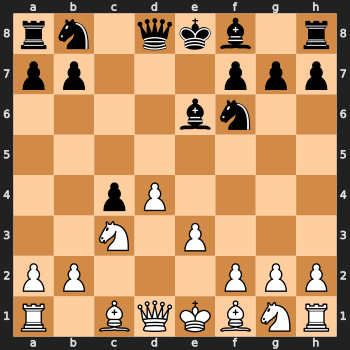

XGB eval [133.2345]
Stockfish eval 181


In [317]:
# test 
fen_str = "rn1qkb1r/pp3ppp/4bn2/8/2pP4/2N1P3/PP3PPP/R1BQKBNR w KQkq - 0 7"
board = chess.Board(fen_str)
display(SVG(chess.svg.board(board=board, size=350)))
feature_vector = generate_feature_vector(board)
feature_vector = np.array(feature_vector)
score = model.predict(feature_vector.reshape(1, -1))
print(f'XGB eval {score}')
engine_score = get_stockfish_eval(fen_str)
print(f'Stockfish eval {engine_score}')


number of search nodes: 11133


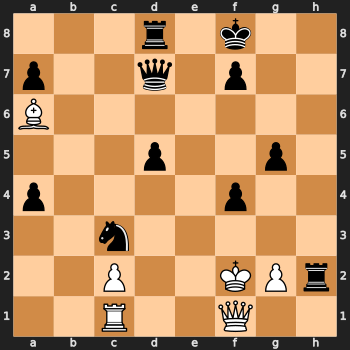

FEN string: 3r1k2/p2q1p2/B7/3p2p1/p4p2/2n5/2P2KPr/2R2Q2 b - - 1 27
Stockfish evaluation: -1299
Model evaluation: -859.1071166992188
Current Game in PGN format:
[Event "?"]
[Site "?"]
[Date "????.??.??"]
[Round "?"]
[White "?"]
[Black "?"]
[Result "*"]

1. d4 Nf6 2. Nf3 d5 3. Bf4 Bf5 4. Nc3 e6 5. e4 dxe4 6. Ne5 h6 7. Bb5+ c6 8. Bc4 Bb4 9. Rc1 Bxc3+ 10. bxc3 g5 11. Bg3 Nbd7 12. Nxd7 Qxd7 13. Rf1 Rh7 14. f3 Rd8 15. h4 exf3 16. Rxf3 b6 17. hxg5 hxg5 18. d5 cxd5 19. Ba6 b5 20. Rxf5 exf5 21. Qe2+ Ne4 22. Bh2 Rxh2 23. Qf1 Nxc3 24. Kf2 Kf8 25. a4 bxa4 26. Bd3 f4 27. Ba6 *


In [325]:
import time

def evaluate_board(board, engine=False):
    # evaluation function
    if board.is_checkmate() and board.turn == chess.WHITE:
        return -10000
    elif board.is_checkmate() and board.turn == chess.BLACK:
        return 10000

    if not engine:
        # use model
        feature_vector = generate_feature_vector(board)
        return model.predict(feature_vector.reshape(1, -1))
    else:
        # use engine
        score = get_stockfish_eval(board.fen())
        return score

def get_ordered_moves(board):
    # Generate all legal moves
    all_moves = list(board.legal_moves)

    capture_moves = []
    check_moves = []
    is_irreversible_moves = []
    castle_moves = []
    pawn_moves = []
    non_capture_moves = []
    piece_moves = []

    for move in all_moves:
        if board.is_capture(move):
            capture_moves.append(move)
        elif board.gives_check(move):
            check_moves.append(move)
        elif board.is_irreversible(move):
            is_irreversible_moves.append(move)
        elif board.is_castling(move):
            castle_moves.append(move)
        elif board.piece_type_at(move.from_square) != chess.PAWN:
            piece_moves.append(move)
        else:
            non_capture_moves.append(move)

        ordered_moves = capture_moves + check_moves + castle_moves + is_irreversible_moves  + piece_moves + non_capture_moves
        ordered_moves_no_duplicates = []
        for move in ordered_moves:
            if move not in ordered_moves_no_duplicates:
                ordered_moves_no_duplicates.append(move)

    return ordered_moves_no_duplicates

# Alpha-Beta pruning with evaluation threshold
def alpha_beta(board, depth, alpha, beta, maximizing, threshold=10000):
    global num_search_nodes
    num_search_nodes += 1
    if depth == 0 or board.is_game_over():
        return evaluate_board(board)
    
    if maximizing:
        max_eval = float('-inf')
        ordered_moves = get_ordered_moves(board)
        for move in ordered_moves:
            board.push(move)
            eval = alpha_beta(board, depth-1, alpha, beta, False, threshold)
            board.pop()
            max_eval = max(max_eval, eval)
            alpha = max(alpha, eval)
            if beta <= alpha:
                break
            if max_eval >= threshold:
                break
        return max_eval
    else:
        min_eval = float('inf')
        ordered_moves = get_ordered_moves(board)
        for move in ordered_moves:
            board.push(move)
            eval = alpha_beta(board, depth-1, alpha, beta, True, threshold)
            board.pop()
            min_eval = min(min_eval, eval)
            beta = min(beta, eval)
            if beta <= alpha:
                break
            if min_eval <= -threshold:
                break
        return min_eval

# Find the best move using minimax with alpha-beta pruning and evaluation threshold
def get_best_move(board, depth):
    a, b = count_pieces(board)
    if a+b >= 30:
        threshold = 50
        depth = 3
    elif a+b >= 28:
        threshold = 200
        depth = 3
    elif a+b >= 26:
        threshold = 400
    else:
        threshold = 1000

    start_time = time.time()
    

    if board.turn == chess.WHITE:  # If it's white's turn
        best_eval = float('-inf')
        maximizing = True
    else:  # If it's black's turn
        best_eval = float('inf')
        maximizing = False

    best_move = None
    # Separate capture and non-capture moves
    ordered_moves = get_ordered_moves(board)
    for move in ordered_moves:
        board.push(move)
        move_eval = alpha_beta(board, depth-1, float('-inf'), float('inf'), not maximizing, threshold)
        board.pop()
        
        if maximizing and move_eval > best_eval:
            best_eval = move_eval
            best_move = move
        elif not maximizing and move_eval < best_eval:
            best_eval = move_eval
            best_move = move
        
        # Stop searching after time limit passes
        if time.time() - start_time > time_limit:
            break

    return best_move

# Initialize 
depth = 4
num_moves = 200
num_search_nodes = 0
time_limit = 15
num_search_nodes = 0
threshold=10000


# Initialize an empty PGN
game = chess.pgn.Game()
# Initialize board
board = chess.Board()
# Create a node to represent the game's starting position
node = game
# Play num_moves moves
for i in range(num_moves):
    if board.is_game_over():
        break
    num_search_nodes = 0
    best_move = get_best_move(board=board, depth=depth)
    print(num_search_nodes)
    board.push(best_move)
    print(board.fen())
    node = node.add_variation(best_move)

    # Clear output
    clear_output(wait=True)
    # Display the board
    print(f'number of search nodes: {num_search_nodes}')
    display(SVG(chess.svg.board(board=board, size=350)))
    print(f'FEN string: {board.fen()}')
    print(f'Stockfish evaluation: {get_stockfish_eval(board.fen())}')
    model_score = model.predict(generate_feature_vector(board).reshape(1, -1))[0]
    print(f'Model evaluation: {model_score}')

    # Export the current game state to a PGN string and print it
    pgn_string = str(game)
    print("Current Game in PGN format:")
    print(pgn_string)
    time.sleep(0.1)

exporter = chess.pgn.StringExporter()
pgn_string = game.accept(exporter)


print("PGN of the game:")
print(pgn_string)
